# Train Random forest tree (regression)

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("df_combined.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)
df = df[df.index >= "2020-10-02"]

# Feature engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Define features and target
features = ['Air Temperature', 'Precipitation Amount', 
           'Snow Depth', 'Sunshine Duration',
           'hour', 'day_of_week', 'month']
target = 'price'

# Scale features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Time-series cross-validation parameters
WINDOW_SIZE = 24 * 7 * 4  # 4 weeks of hourly data
STEP_SIZE = 24 * 7        # 1 week step

# Custom time series split
def moving_window_split(data, window_size, step_size):
    n_samples = len(data)
    for i in range(0, n_samples - window_size - 1, step_size):
        train_end = i + window_size
        test_end = train_end + step_size
        if test_end > n_samples:
            break
        yield (np.arange(i, train_end), np.arange(train_end, test_end))

# Initialize model with best parameters (run grid search first)
best_params = {
    'n_estimators': 200,
    'max_depth': 15,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42
}

model = RandomForestRegressor(**best_params)

# Store evaluation metrics
metrics = {'mae': [], 'rmse': [], 'r2': []}
actuals = []
predictions = []

# Moving window cross-validation
for train_idx, test_idx in moving_window_split(df, WINDOW_SIZE, STEP_SIZE):
    # Split data
    X_train = df.iloc[train_idx][features]
    y_train = df.iloc[train_idx][target]
    X_test = df.iloc[test_idx][features]
    y_test = df.iloc[test_idx][target]
    
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Store results
    actuals.extend(y_test)
    predictions.extend(y_pred)
    
    # Calculate metrics
    metrics['mae'].append(mean_absolute_error(y_test, y_pred))
    metrics['rmse'].append(root_mean_squared_error(y_test, y_pred))
    metrics['r2'].append(r2_score(y_test, y_pred))


## Display results


Average Metrics:
MAE: 38.41
RMSE: 48.92
R²: -1.19


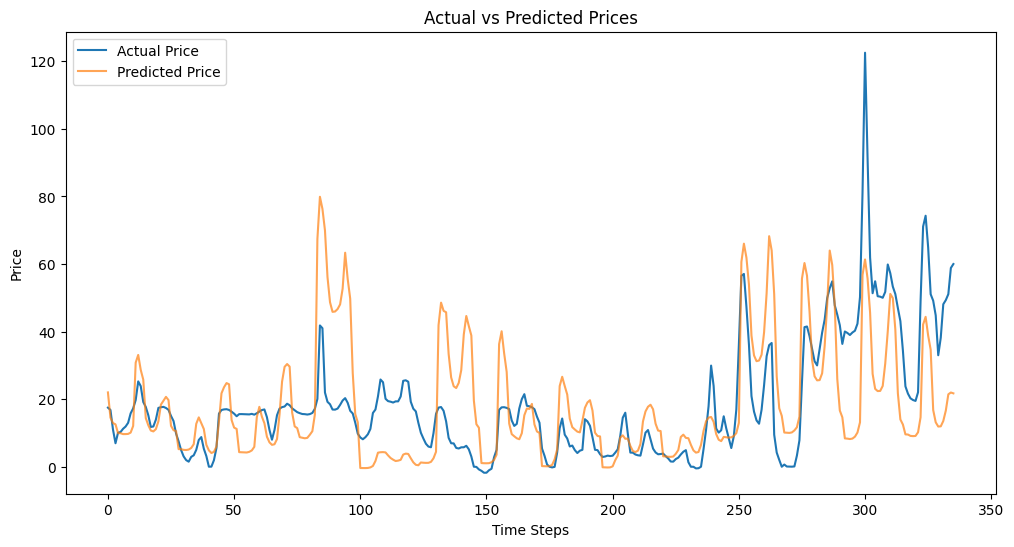

In [3]:

# Calculate average metrics
avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
print("\nAverage Metrics:")
print(f"MAE: {avg_metrics['mae']:.2f}")
print(f"RMSE: {avg_metrics['rmse']:.2f}")
print(f"R²: {avg_metrics['r2']:.2f}")

# Plot feature importance
# feature_importance = pd.Series(model.feature_importances_, index=features)
# feature_importance.sort_values().plot(kind='barh', title='Feature Importance')
# plt.show()

n=14*24
p_actuals = actuals[-n:]
p_prediction= predictions[-n:]

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(p_actuals, label='Actual Price')
plt.plot(p_prediction, label='Predicted Price', alpha=0.7)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

In [4]:
import xgboost as xgb


model_params = {
    'n_estimators': 300,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42
}

# Initialize model with fixed parameters
optimized_model = xgb.XGBRegressor(**model_params)

# Store evaluation metrics
metrics = {'mae': [], 'rmse': [], 'r2': []}
actuals = []
predictions = []
forecast_dates = []

# Moving window cross-validation
for train_idx, test_idx in moving_window_split(df, WINDOW_SIZE, STEP_SIZE):
    # Split data
    X_train = df.iloc[train_idx][features]
    y_train = df.iloc[train_idx][target]
    X_test = df.iloc[test_idx][features]
    y_test = df.iloc[test_idx][target]
    
    # Train and predict
    optimized_model.fit(X_train, y_train,
                       eval_set=[(X_test, y_test)],
                       verbose=0)
    
    y_pred = optimized_model.predict(X_test)
    
    # Store results
    actuals.extend(y_test)
    predictions.extend(y_pred)
    forecast_dates.extend(df.index[test_idx])
    
    # Calculate metrics
    metrics['mae'].append(mean_absolute_error(y_test, y_pred))
    metrics['rmse'].append(root_mean_squared_error(y_test, y_pred))
    metrics['r2'].append(r2_score(y_test, y_pred))



Average Metrics:
MAE: 38.2367
RMSE: 48.4479
R²: -1.0586


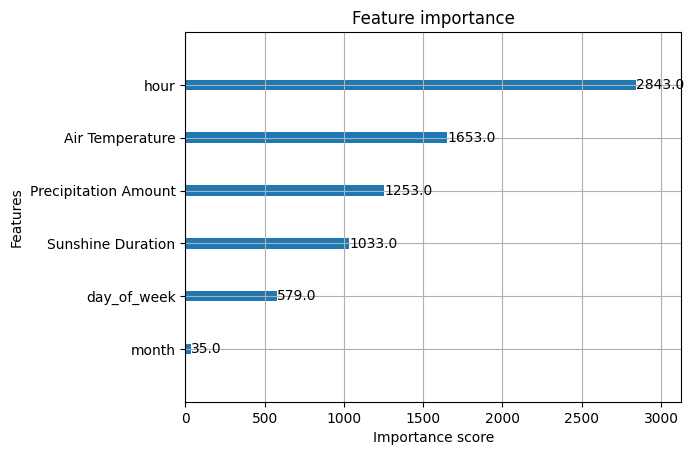

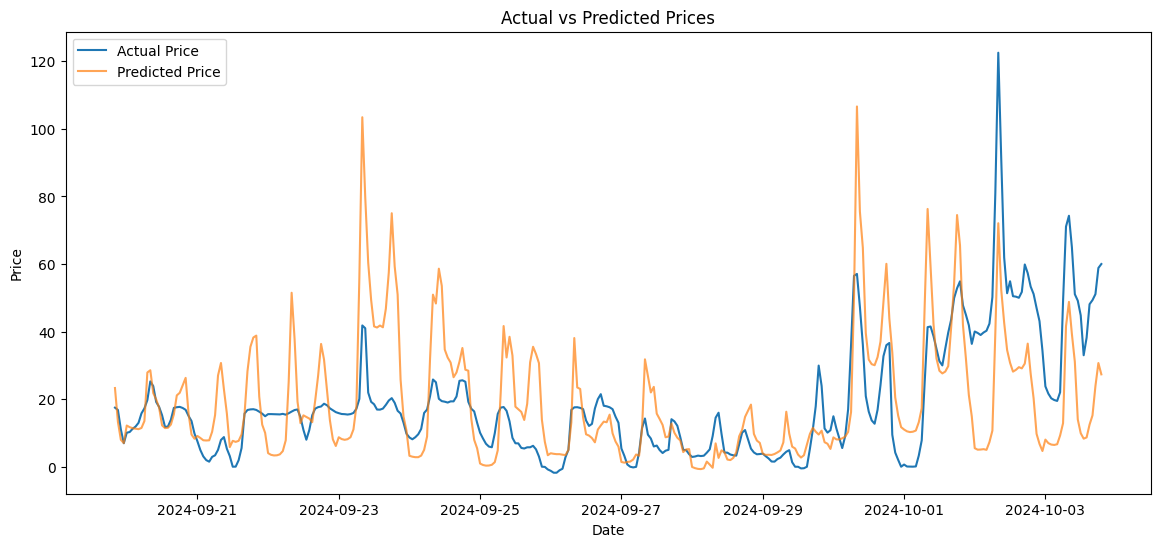

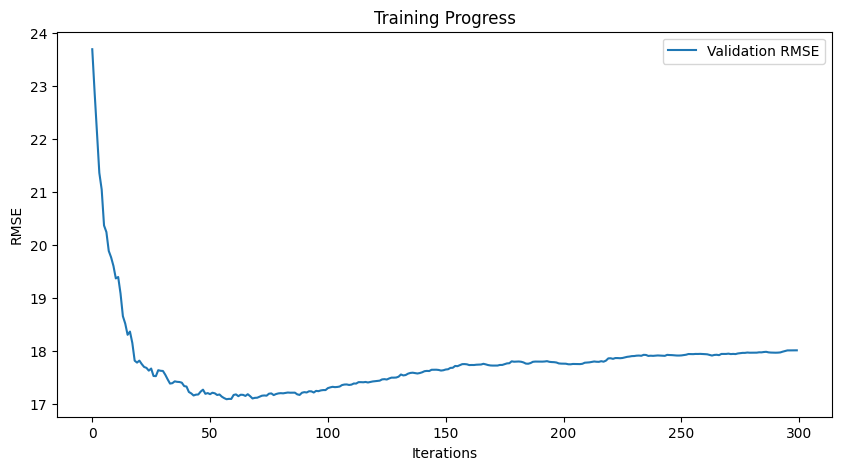

In [5]:

# Calculate average metrics
avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
print("\nAverage Metrics:")
print(f"MAE: {avg_metrics['mae']:.4f}")
print(f"RMSE: {avg_metrics['rmse']:.4f}")
print(f"R²: {avg_metrics['r2']:.4f}")

# Plot feature importance
xgb.plot_importance(optimized_model, max_num_features=10)
plt.show()

n = 24*14

# Plot actual vs predicted with dates
results_df = pd.DataFrame({
    'date': forecast_dates[-n:],
    'actual': actuals[-n:],
    'predicted': predictions[-n:]
}).set_index('date')

plt.figure(figsize=(14, 6))
plt.plot(results_df['actual'], label='Actual Price')
plt.plot(results_df['predicted'], label='Predicted Price', alpha=0.7)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot training progress
results = optimized_model.evals_result()
plt.figure(figsize=(10, 5))
plt.plot(results['validation_0']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Progress')
plt.legend()
plt.show()